In [1]:
import pandas as pd

In [2]:
# Load news CSV file
file_path = 'news.csv'
news_data = pd.read_csv(file_path)

/var/folders/zt/nyys066105lblq7tgvfcr7bw0000gq/T/ipykernel_68385/3261319258.py:3: DtypeWarning: Columns (2,4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  news_data = pd.read_csv(file_path)


In [3]:
# Initial inspection: show the first few rows of the dataset
news_data.head()

,Date,Article_title,Stock_symbol,Url,Publisher,Author,Article,Lsa_summary,Luhn_summary,Textrank_summary,Lexrank_summary
0,2020-06-05 06:30:54 UTC,Stocks That Hit 52-Week Highs On Friday,A,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-06-03 06:45:20 UTC,Stocks That Hit 52-Week Highs On Wednesday,A,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-05-26 00:30:07 UTC,71 Biggest Movers From Friday,A,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-05-22 08:45:06 UTC,46 Stocks Moving In Friday's Mid-Day Session,A,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-05-22 07:38:59 UTC,B of A Securities Maintains Neutral on Agilent...,A,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Dataset dimensions
print("\nDataset dimensions: ", news_data.shape)


Dataset dimensions:  (13057514, 11)


In [5]:
# Data types of each column
print("\nData types for each column: ", news_data.dtypes)


Data types for each column:  Date                 object
Article_title        object
Stock_symbol         object
Url                  object
Publisher            object
Author               object
Article              object
Lsa_summary         float64
Luhn_summary        float64
Textrank_summary    float64
Lexrank_summary     float64
dtype: object


In [6]:
# Check for missing values
print("Missing values in each column:")
print("-"*30)
print(news_data.isnull().sum())

Missing values in each column:
------------------------------
Date                       0
Article_title              1
Stock_symbol         9804627
Url                      686
Publisher            9030871
Author              11871199
Article             11809202
Lsa_summary         13057514
Luhn_summary        13057514
Textrank_summary    13057514
Lexrank_summary     13057514
dtype: int64


In [7]:
# Descriptive statistics for numeric columns
print("Descriptive statistics for numeric columns:")
print(news_data.describe())

Descriptive statistics for numeric columns:
       Lsa_summary  Luhn_summary  Textrank_summary  Lexrank_summary
count          0.0           0.0               0.0              0.0
mean           NaN           NaN               NaN              NaN
std            NaN           NaN               NaN              NaN
min            NaN           NaN               NaN              NaN
25%            NaN           NaN               NaN              NaN
50%            NaN           NaN               NaN              NaN
75%            NaN           NaN               NaN              NaN
max            NaN           NaN               NaN              NaN


___

In [8]:
# Rimuovere le colonne vuote e inutili
news_data_cleaned = news_data.drop(columns=['Lsa_summary', 'Luhn_summary', 'Textrank_summary', 'Lexrank_summary'])

In [9]:
# Rimuovere le righe con valori mancanti nelle colonne chiave (Stock_symbol e Article_title)
news_data_cleaned = news_data_cleaned.dropna(subset=['Stock_symbol', 'Article_title'])

In [10]:
# Mostrare una sintesi del dataset pulito
print("Dataset cleaned dimensions:", news_data_cleaned.shape)

Dataset cleaned dimensions: (3252887, 7)


In [11]:
# Verifica dei dati mancanti dopo la pulizia
print("Missing values in each column after cleaning:")
print(news_data_cleaned.isnull().sum())

Missing values in each column after cleaning:
Date                   0
Article_title          0
Stock_symbol           0
Url                    0
Publisher              0
Author           3252887
Article          3252887
dtype: int64


In [12]:
# Ridurre il dataset alle sole colonne di interesse
news_data_reduced = news_data_cleaned[['Date', 'Stock_symbol', 'Article_title']]

In [13]:
news_data_reduced.head()

,Date,Stock_symbol,Article_title
0,2020-06-05 06:30:54 UTC,A,Stocks That Hit 52-Week Highs On Friday
1,2020-06-03 06:45:20 UTC,A,Stocks That Hit 52-Week Highs On Wednesday
2,2020-05-26 00:30:07 UTC,A,71 Biggest Movers From Friday
3,2020-05-22 08:45:06 UTC,A,46 Stocks Moving In Friday's Mid-Day Session
4,2020-05-22 07:38:59 UTC,A,B of A Securities Maintains Neutral on Agilent...


In [14]:
print("Reduced dataset dimensions:", news_data_reduced.shape)

Reduced dataset dimensions: (3252887, 3)


### Distribuzione Temporale delle Notizie

In [19]:
# Convertire la colonna 'Date' in formato datetime per una corretta analisi temporale
news_data_reduced.loc[:, 'Date'] = pd.to_datetime(news_data_reduced['Date'], errors='coerce')
# news_data_reduced['Date'] = pd.to_datetime(news_data_reduced['Date'], errors='coerce')

In [23]:
# Distribuzione temporale delle notizie per anno
news_by_year = news_data_reduced['Date'].dt.year.value_counts().sort_index()
news_by_year

Date
1969         1
2009     11489
2010     94198
2011    177982
2012    234050
2013    212044
2014    245022
2015    417215
2016    374937
2017    285913
2018    479525
2019    518954
2020    201557
Name: count, dtype: int64

- Il dataset copre principalmente il periodo dal 2009 al 2020, con un picco di notizie tra il 2015 e il 2019. L’anno 2020 ha significativamente meno notizie, probabilmente perché il dataset è incompleto per quell’anno.
- Ci sono pochissime notizie nel 1969, che sembra essere un’anomalia.

### Distribuzione per Azienda

In [24]:
# Distribuzione delle notizie per azienda (Stock_symbol)
news_by_symbol = news_data_reduced['Stock_symbol'].value_counts().head(20)  # Mostra i primi 20 ticker con più notizie
news_by_symbol

Stock_symbol
KR      5127
GILD    4974
DISH    4624
EWJ     4526
MDT     4476
HD      4453
MYL     4446
JWN     4432
FDX     4399
FCAU    4334
FCX     4296
WDC     4219
GRPN    4192
AVGO    4149
VMW     4104
TWX     4099
SLV     4012
CSX     4007
BLK     3989
EA      3938
Name: count, dtype: int64

### Dataset 2013-2019

In [25]:
# Limitare il dataset al periodo 2015-2019
news_data_reduced = news_data_reduced[(news_data_reduced['Date'].dt.year >= 2015) & (news_data_reduced['Date'].dt.year <= 2019)]

In [26]:
print("Dimensions of the dataset after limiting to 2015-2019: ", news_data_reduced.shape)

Dimensions of the dataset after limiting to 2015-2019:  (2076544, 3)


__

In [27]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [28]:
# Assicurarsi di avere i dati di stopwords e sentiment se non sono già installati
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/LucaBia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/LucaBia/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [29]:
# Inizializza l'analizzatore di sentiment
sia = SentimentIntensityAnalyzer()

In [30]:
# Definire uno stopword set
stop_words = set(stopwords.words('english'))

In [31]:
# Funzione per pulire il testo
def clean_text(text):
    # Rimuovere punteggiatura e numeri
    text = re.sub(r'[^A-Za-z\s]', '', text)
    # Convertire il testo a minuscolo
    text = text.lower()
    # Rimuovere stopwords
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

In [32]:
# Applicare la pulizia del testo ai titoli
news_data_reduced['Cleaned_Title'] = news_data_reduced['Article_title'].apply(clean_text)


In [33]:
# Funzione per calcolare il sentiment utilizzando VADER
def get_sentiment(text):
    score = sia.polarity_scores(text)
    return score['compound']  # Usa il punteggio compound che va da -1 a 1

In [34]:
# Calcolare il sentiment per ciascun titolo
news_data_reduced['Sentiment'] = news_data_reduced['Cleaned_Title'].apply(get_sentiment)

In [35]:
news_data_reduced[['Article_title', 'Cleaned_Title', 'Sentiment']].head()

,Article_title,Cleaned_Title,Sentiment
70,Stocks That Hit 52-Week Highs On Friday,stocks hit week highs friday,0.0
71,Stocks That Hit 52-Week Highs On Monday,stocks hit week highs monday,0.0
72,Stocks That Hit 52-Week Highs On Friday,stocks hit week highs friday,0.0
73,Stocks That Hit 52-Week Highs On Thursday,stocks hit week highs thursday,0.0
74,There's A New Trading Tool That Allows Traders...,theres new trading tool allows traders trade c...,0.0


Graph saved as sentiment_distribution.png


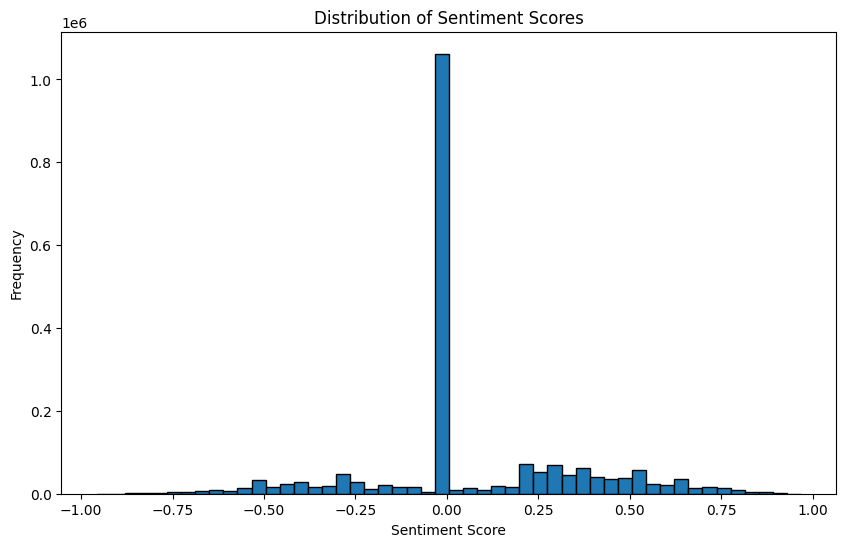

In [36]:
# import os
# os.environ['MPLBACKEND'] = 'Agg'
import matplotlib.pyplot as plt

# Forza un backend sicuro direttamente dalle variabili d'ambiente se hai accesso a eseguire bash:

# Visualizzare la distribuzione del sentiment
plt.figure(figsize=(10, 6))
plt.hist(news_data_reduced['Sentiment'], bins=50, edgecolor='k')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')

print("Graph saved as sentiment_distribution.png")

In [39]:
# Estrazione di titoli con sentiment molto positivo (> 0.5) o molto negativo (< -0.5)
extreme_positive = news_data_reduced[news_data_reduced['Sentiment'] > 0.5]
extreme_negative = news_data_reduced[news_data_reduced['Sentiment'] < -0.5]

# Visualizza i primi 5 titoli con sentiment positivo e negativo estremi
print("Titoli con sentiment molto positivo:")
print(extreme_positive[['Article_title', 'Sentiment']].head())

print("\nTitoli con sentiment molto negativo:")
extreme_negative[['Article_title', 'Sentiment']].head()

Titoli con sentiment molto positivo:
                                         Article_title  Sentiment
94   Shares of several healthcare companies are tra...     0.7351
96   Shares of several healthcare companies are tra...     0.6124
98   Shares of several healthcare companies are tra...     0.7650
111  Shares of diagnostics and research companies a...     0.7906
113  Agilent Announces Settlement of Key Intellectu...     0.5106

Titoli con sentiment molto negativo:


,Article_title,Sentiment
97,Shares of several healthcare companies are tra...,-0.8126
112,Shares of several gold companies are trading h...,-0.5719
228,Aquinox Pharmaceuticals Announces FDA Panel Vo...,-0.5106
264,Agilent Reports Deal with Agendia for Molecula...,-0.6597
342,Agilent Subsidiary Dako Reports Commercial Ava...,-0.6597


In [40]:
# Estrai un campione casuale di titoli con sentiment neutro (0)
neutral_titles_sample = news_data_reduced[news_data_reduced['Sentiment'] == 0].sample(10)

# Mostra il campione di titoli neutrali
neutral_titles_sample[['Article_title', 'Sentiment']]

,Article_title,Sentiment
1317068,5 Manufacturing Stocks With 25% Upside Potential,0.0
3313173,ArcelorMittal to Invest $1 Billion at Mexican ...,0.0
1251528,TrustCo Bank Reports Q1 EPS $0.11,0.0
2674504,Diana Shipping announces new time charter cont...,0.0
2616423,Corning has more Upside to Offer and Here's Why,0.0
3896848,The Ultratech Two-Step Continues,0.0
2971388,"The Home Depot, Inc. (HD) CEO Craig Menear on ...",0.0
2312381,Add These 4 Low P/CF Stocks to Create a Value-...,0.0
3862539,HBO sets 'Game of Thrones' premiere for April 24,0.0
3685301,The Vetr community has upgraded $SKX to 4.5-St...,0.0


__

In [72]:
financial_data = pd.read_csv('sp500_historical_prices.csv')

In [73]:
financial_data.head()

,DATE,TRDPRC_1,HIGH_1,LOW_1,OPEN_PRC,BID,ASK,TRNOVR_UNS,NUM_MOVES,RIC
0,2022-12-30,71.94,72.15,71.50,71.66,71.94,71.95,39211033.0,2667.0,AFL.N
1,2022-12-29,72.08,72.38,71.62,71.77,72.09,72.10,37359210.0,2814.0,AFL.N
2,2022-12-28,71.47,72.50,71.46,72.50,71.46,71.48,37532980.0,2835.0,AFL.N
3,2022-12-27,72.24,72.61,71.92,72.00,72.24,72.26,39323197.0,2917.0,AFL.N
4,2022-12-23,71.75,71.81,70.91,70.91,71.76,71.78,34382305.0,2413.0,AFL.N


In [75]:
print("Dimensions of the dataset:", financial_data.shape)
print("Data types for each column:\n", financial_data.dtypes)

Dimensions of the dataset: (1212200, 10)
Data types for each column:
 DATE           object
TRDPRC_1      float64
HIGH_1        float64
LOW_1         float64
OPEN_PRC      float64
BID           float64
ASK           float64
TRNOVR_UNS    float64
NUM_MOVES     float64
RIC            object
dtype: object


In [76]:
financial_data['DATE'] = pd.to_datetime(financial_data['DATE'])

In [77]:
financial_data = financial_data.sort_values(by=['RIC', 'DATE'])

In [86]:
financial_data['Return'] = financial_data.groupby('RIC')['TRDPRC_1'].pct_change()
# financial_data['Return'] = financial_data.groupby('RIC')['TRDPRC_1'].diff()

/var/folders/zt/nyys066105lblq7tgvfcr7bw0000gq/T/ipykernel_68385/3069139386.py:1: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  financial_data['Return'] = financial_data.groupby('RIC')['TRDPRC_1'].pct_change()


In [87]:
financial_data.head()

,DATE,TRDPRC_1,HIGH_1,LOW_1,OPEN_PRC,BID,ASK,TRNOVR_UNS,NUM_MOVES,RIC,Return
858637,2013-01-02,29.947844,29.997900,29.425830,29.947844,29.940693,29.947844,NaN,4048.0,A.N,NaN
858636,2013-01-03,30.055107,30.133766,29.740468,29.990749,30.047956,30.055107,NaN,2661.0,A.N,0.003582
858635,2013-01-04,30.648629,30.705836,29.940693,30.133766,30.641478,30.648629,NaN,2802.0,A.N,0.019748
858634,2013-01-07,30.426952,30.598573,30.312538,30.462706,30.426952,30.434103,NaN,1491.0,A.N,-0.007233
858633,2013-01-08,30.183822,30.591422,30.112314,30.369745,30.190973,30.198124,NaN,1650.0,A.N,-0.007991


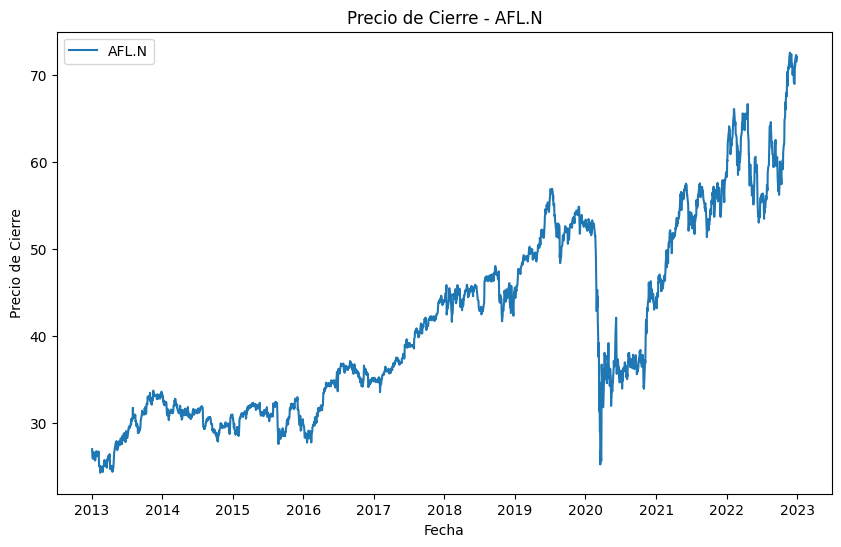

In [88]:
company_data = financial_data[financial_data['RIC'] == 'AFL.N']
plt.figure(figsize=(10, 6))
plt.plot(company_data['DATE'], company_data['TRDPRC_1'], label='AFL.N')
plt.title('Precio de Cierre - AFL.N')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.legend()
plt.show()

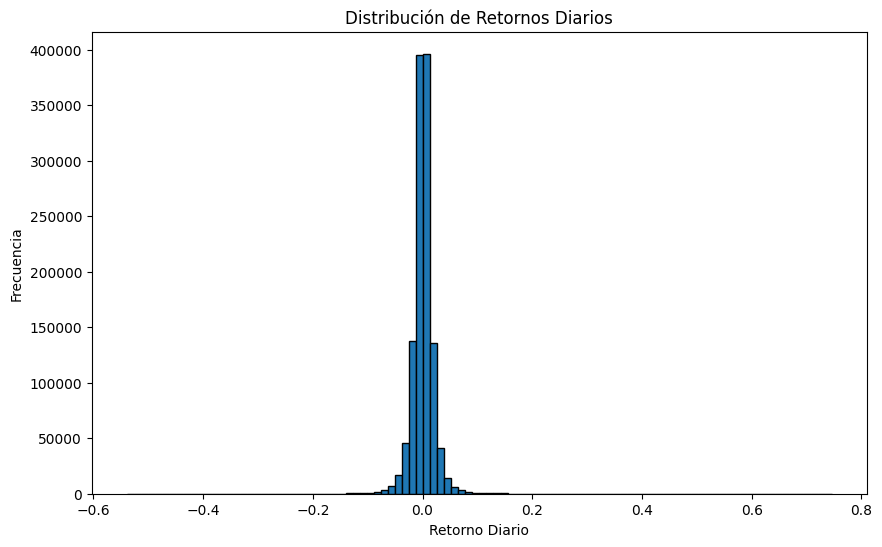

In [89]:
plt.figure(figsize=(10, 6))
plt.hist(financial_data['Return'].dropna(), bins=100, edgecolor='k')
plt.title('Distribución de Retornos Diarios')
plt.xlabel('Retorno Diario')
plt.ylabel('Frecuencia')
plt.show()